# Boston Housing Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset and give headers
df = pd.read_csv('housing.csv', header=None)
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


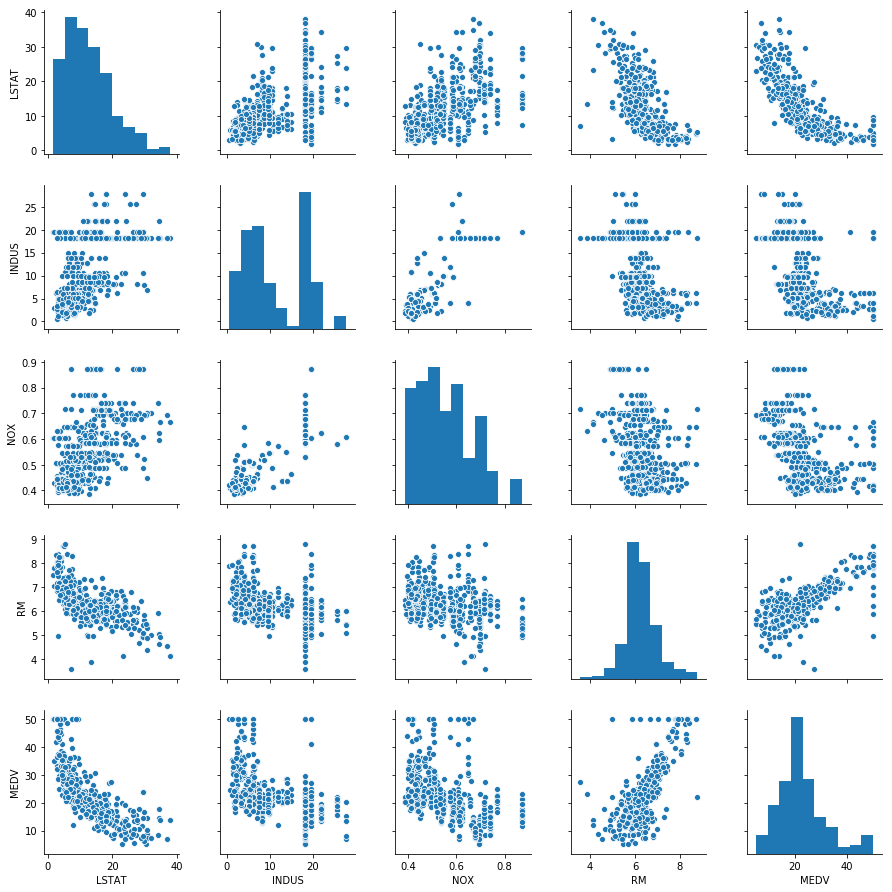

In [4]:
# create pairplot
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

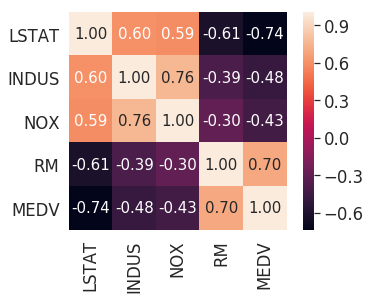

In [5]:
# create correlation matrix
cm = np.corrcoef(df[cols].values.T)

# create heatmap
sns.set(font_scale=1.5)
hm = sns.heatmap(
    cm, cbar=True, annot=True, 
    square=True, fmt='.2f',
    annot_kws={'size': 15},
    yticklabels=cols,
    xticklabels=cols)
plt.show()

# Implementing OLS Linear Regression

In [6]:
from linearregressiongd import LinearRegressionGD
from sklearn.preprocessing import StandardScaler

X = df[['RM']].values
y = df['MEDV'].values

# initalize and fit scalers
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

# intialize and fit linear regression model
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

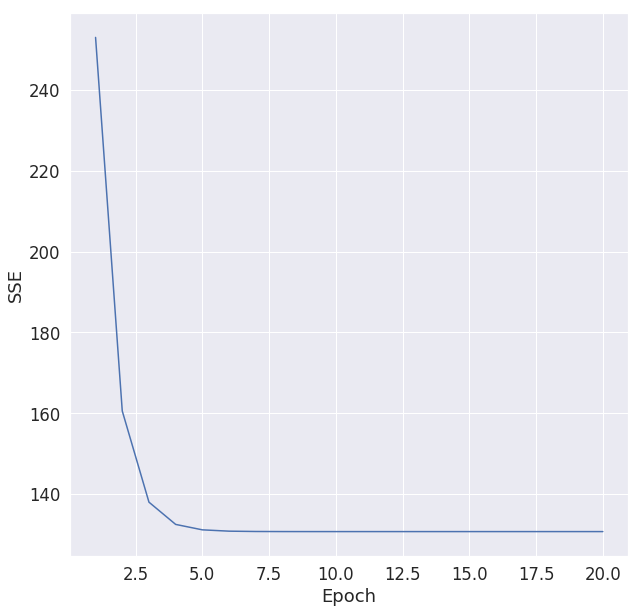

In [7]:
# plot
plt.figure(figsize=(10, 10))
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [8]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

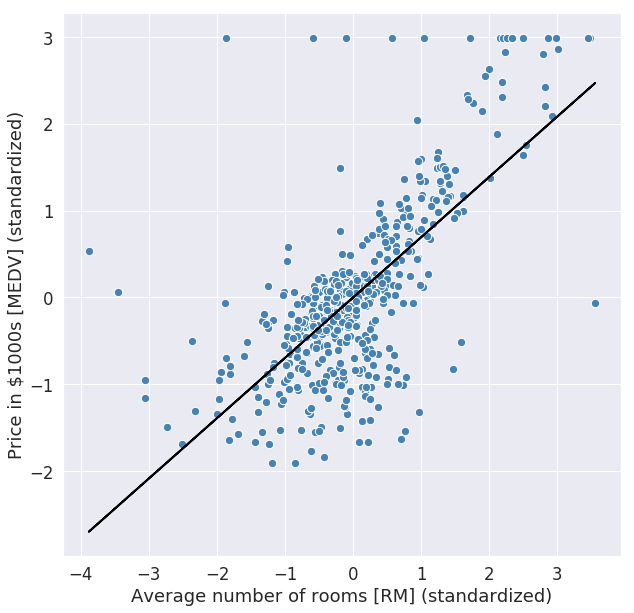

In [9]:
plt.figure(figsize=(10, 10))
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [10]:
num_rooms_std = sc_x.transform(np.array(5.0).reshape(-1, 1))
price_std = lr.predict(num_rooms_std)

pred_price_std = sc_y.inverse_transform(price_std)
print(pred_price_std)

print(f"Price in $1000s: {pred_price_std[0]:.3f}")

[10.83993289]
Price in $1000s: 10.840


In [11]:
print(f'Slope:\t\t {lr.w_[1]:.3f}')
print(f'Intercept:\t {lr.w_[0]:.3f}')

Slope:		 0.695
Intercept:	 -0.000


# Estimating Coefficient of a Regression Model via `scikit-learn`

In [12]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)

print(f'Slope:\t\t {slr.coef_[0]:.3f}')
print(f'Intercept:\t {slr.intercept_:.3f}')

Slope:		 9.102
Intercept:	 -34.671


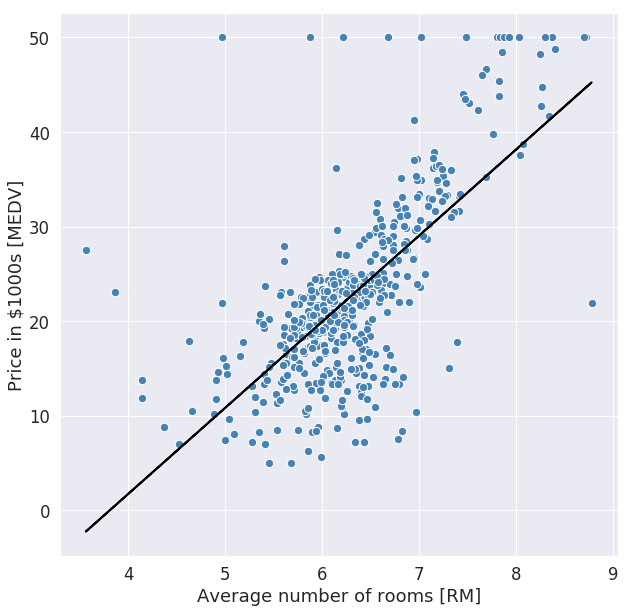

In [13]:
plt.figure(figsize=(10, 10))
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

# Robust Regression Models Using RANSAC

In [14]:
from sklearn.linear_model import RANSACRegressor

# initialize and fit RANSAC regressor
ransac = RANSACRegressor(
    LinearRegression(), 
    max_trials=100, 
    min_samples=50, 
    loss='absolute_loss', 
    residual_threshold=5.0, 
    random_state=0
)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=50, random_state=0,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

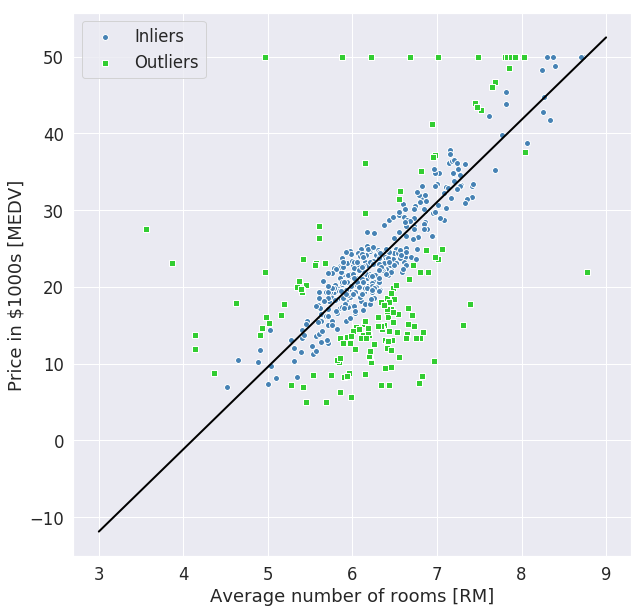

In [15]:
# obtain inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# make predictions
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

# plot
plt.figure(figsize=(10, 10))
plt.scatter(
    X[inlier_mask], y[inlier_mask],
    c='steelblue', edgecolor='white', 
    marker='o', label='Inliers'
)
plt.scatter(
    X[outlier_mask], y[outlier_mask],
    c='limegreen', edgecolor='white', 
    marker='s', label='Outliers'
)
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [16]:
print(f'Slope:\t\t {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept:\t {ransac.estimator_.intercept_:.3f}')

Slope:		 10.735
Intercept:	 -44.089


# Evaluating Performance

In [17]:
from sklearn.model_selection import train_test_split

# prepare data
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# initialize and fit linear regression model
slr = LinearRegression()
slr.fit(X_train, y_train)

# make predictions
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

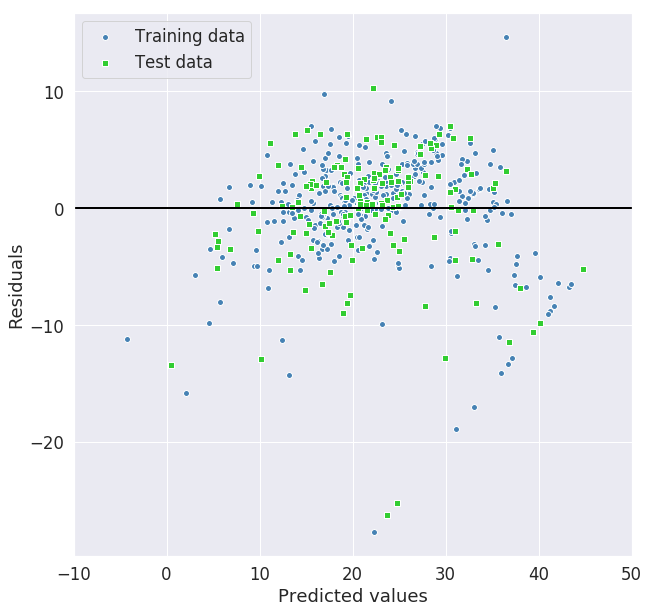

In [18]:
# create residual plot
plt.figure(figsize=(10, 10))
plt.scatter(
    y_train_pred,  y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data'
)
plt.scatter(
    y_test_pred,  y_test_pred - y_test,
    c='limegreen', marker='s', edgecolor='white',
    label='Test data'
)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

print(f'MSE train:\t {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE test:\t {mean_squared_error(y_test, y_test_pred):.3f}')

MSE train:	 19.958
MSE test:	 27.196


In [20]:
from sklearn.metrics import r2_score

print(f'R^2 train:\t {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 test:\t {r2_score(y_test, y_test_pred):.3f}')

R^2 train:	 0.765
R^2 test:	 0.673


# Using Regularized Methods

In [21]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)

In [22]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)

In [23]:
from sklearn.linear_model import ElasticNet

elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Polynomial Regression

In [24]:
from sklearn.preprocessing import PolynomialFeatures

# create dummy data
X = np.array(
    [258.0, 270.0, 294.0, 320.0, 342.0, 
     368.0, 396.0, 446.0, 480.0, 586.0]
)[:, np.newaxis]

y = np.array(
    [236.4, 234.4, 252.8, 298.6, 314.2, 
     342.2, 360.8, 368.0, 391.2, 390.8]
)

lr = LinearRegression()                    # initialize linreg model
pr = LinearRegression()                    # initialize polyreg model
quadratic = PolynomialFeatures(degree=2)   # set d = 2
X_quad = quadratic.fit_transform(X)        # transform features

In [25]:
# fit linreg model
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [26]:
# fit polyreg model
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

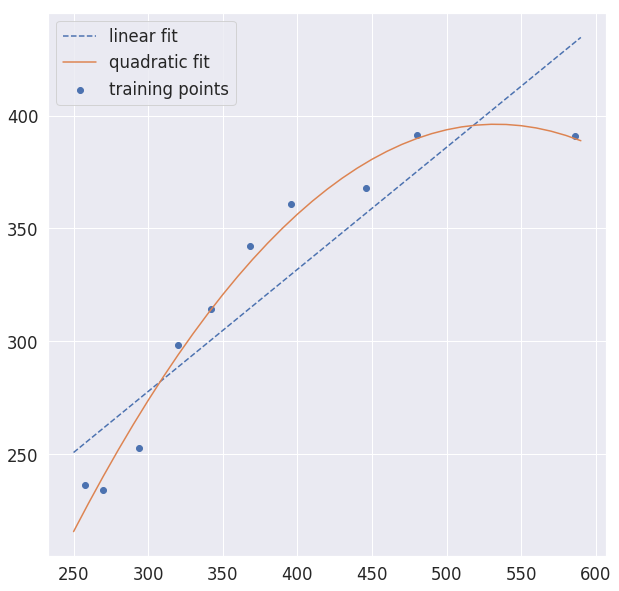

In [27]:
# plot
plt.figure(figsize=(10, 10))
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [28]:
# make predictions
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

# calculate MSE and R-squared
print(f'Training MSE linear:\t {mean_squared_error(y, y_lin_pred):.3f}')
print(f'Training MSE quadratic:\t {mean_squared_error(y, y_quad_pred):.3f}')
print(f'Training R^2 linear:\t {r2_score(y, y_lin_pred):.3f}')
print(f'Training R^2 quadratic:\t {r2_score(y, y_quad_pred):.3f}')

Training MSE linear:	 569.780
Training MSE quadratic:	 61.330
Training R^2 linear:	 0.832
Training R^2 quadratic:	 0.982


In [29]:
X = df[['LSTAT']].values
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
y = df['MEDV'].values

# create quadratic and cubic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

In [30]:
# fit linreg model, make predictions, calculate R-squared
regr = LinearRegression()
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

In [31]:
# fit quadratic model, make predictions, calculate R-squared
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

In [32]:
# fit cubic model, make predictions, calculate R-squared
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

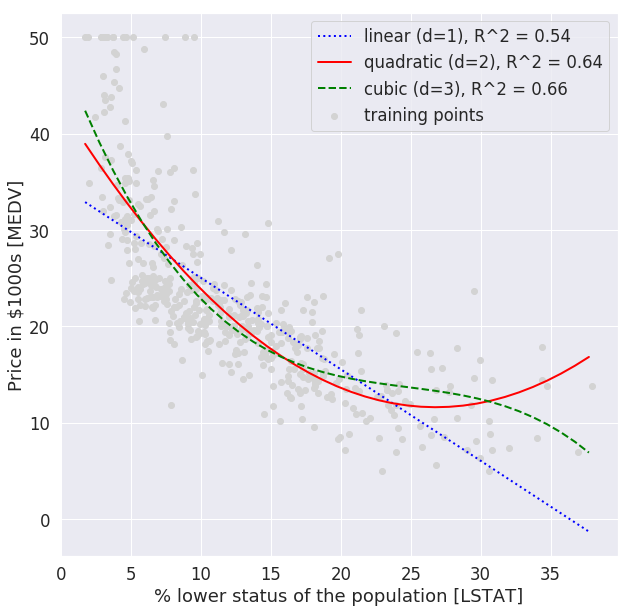

In [33]:
# plot results
plt.figure(figsize=(10, 10))
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(
    X_fit, y_lin_fit,
    label=f'linear (d=1), R^2 = {linear_r2:.2f}',
    color='blue', lw=2, linestyle=':'
)
plt.plot(
    X_fit, y_quad_fit,
    label=f'quadratic (d=2), R^2 = {quadratic_r2:.2f}',
    color='red', lw=2, linestyle='-'
)
plt.plot(
    X_fit, y_cubic_fit,
    label=f'cubic (d=3), R^2 = {cubic_r2:.2f}',
    color='green', lw=2, linestyle='--'
)

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

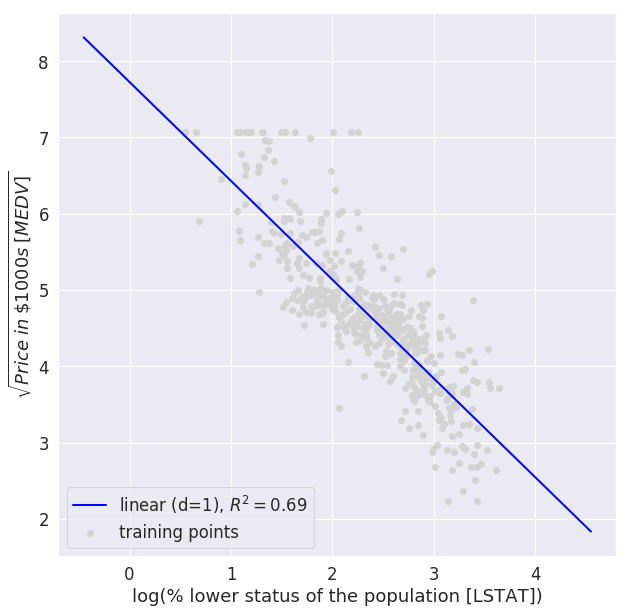

In [34]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.figure(figsize=(10, 10))
plt.scatter(
    X_log, y_sqrt,
    label='training points',
    color='lightgray'
)
plt.plot(
    X_fit, y_lin_fit, 
    label='linear (d=1), $R^2=%.2f$' % linear_r2,
    color='blue', lw=2
)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

# Dealing with Nonlinear Relationships Using Random Forests

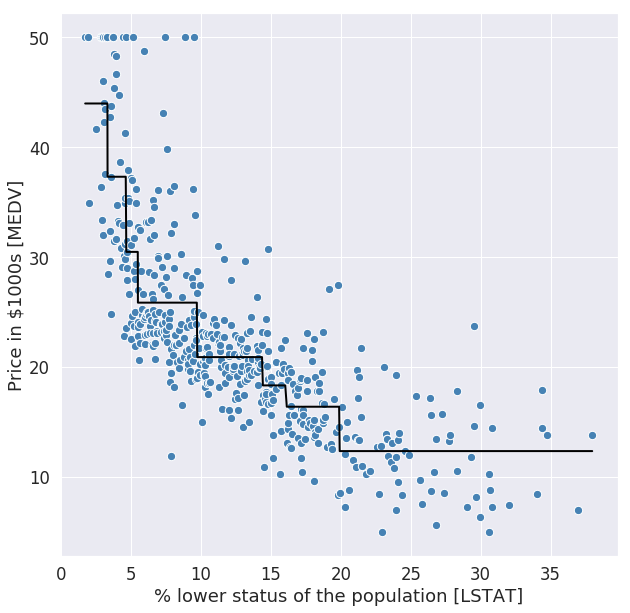

In [35]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

# initialize and fit decision tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

# plot
plt.figure(figsize=(10, 10))
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [36]:
from sklearn.ensemble import RandomForestRegressor

# define features and target and split into train and test sets
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=1
)

# initalize and fit rf regressor
forest = RandomForestRegressor(
    n_estimators=1000, 
    criterion='mse', 
    random_state=1, 
    n_jobs=-1
)
forest.fit(X_train, y_train)

# make predictions
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# calculate mse and r2
print(f'MSE train:\t {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE test:\t {mean_squared_error(y_test, y_test_pred):.3f}')
print(f'R^2 train:\t {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 test:\t {r2_score(y_test, y_test_pred):.3f}')

MSE train:	 1.641
MSE test:	 11.056
R^2 train:	 0.979
R^2 test:	 0.878


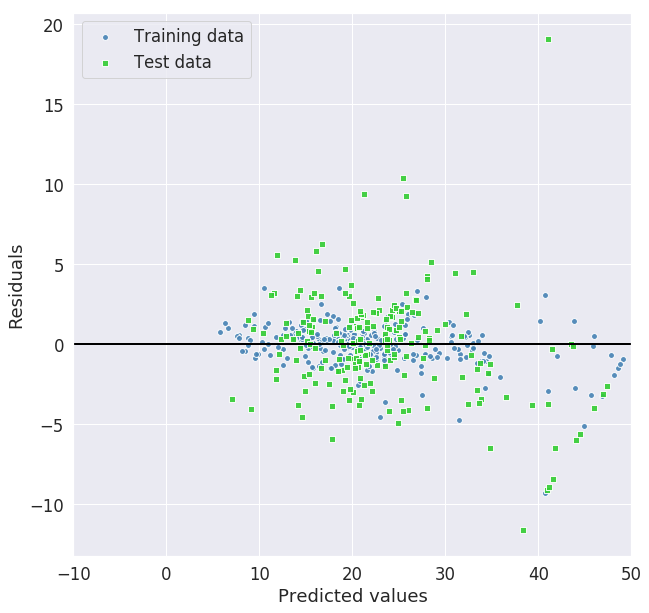

In [37]:
# plot residuals
plt.figure(figsize=(10, 10))
plt.scatter(
    y_train_pred, y_train_pred - y_train,
    c='steelblue', edgecolor='white',
    marker='o', s=35,
    alpha=0.9, label='Training data'
)
plt.scatter(
    y_test_pred, y_test_pred - y_test,
    c='limegreen', edgecolor='white',
    marker='s', s=35,
    alpha=0.9, label='Test data'
)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.show()